# Program to evaluate performance and success rates
Most of this figures and tests are not part of the paper, but needed to be done to evaluate mice performances and validate some assumptions. The queries you will see was originally just one query used for nearly all plots and calculations. So the queries are sometimes a bit more blown up than it is actually needed. But it might be a good example of pandas processing of data that doesn't come in a perfectly fitting version from the database. Run the code by uncommenting the desired function at the bottom of the program (you can also uncomment all) and press `CELL -> RUN ALL`

In [852]:
import pandas as pd
import numpy as np
from sklearn import metrics, svm
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.anova import AnovaRM
import researchpy as rp
from numpy import log
from scipy.stats import norm
from connections import database_password as DBpwd
from connections import database_host as DBhost
from connections import database as DB

from scipy import stats
import matplotlib.pyplot as plt
import pymysql
import seaborn as sns
from random import randint
rand = (randint(0, 1000000))
DBuser = "guest{0}".format(rand)
print(DBuser)

filteredtaglist=["201608466","201608468","201608481","201609136","201609336","210608298","2016080026",
                 "2016090793","2016090943",
                 "2016090629","2016090797","2016090882","2016090965","2016090985","2016091183",
                 "201608252","201608423","201608474",
                 "801010270","801010219","801010205"]
##  standard get from database connection  ##
def getFromDatabase(query):
    db2 = pymysql.connect(host=DBhost, user=DBuser, db=DB, password=DBpwd)
    cur2 = db2.cursor()
    try:
        cur2.execute(query)
        rows = cur2.fetchall()
    except pymysql.Error as e:
        try:
            print("MySQL Error [%d]: %s" % (e.args[0], e.args[1]))
            return None
        except IndexError:
            print("MySQL Error: %s" % str(e))
            return None
    except TypeError as e:
        print("MySQL Error: TypeError: %s" % str(e))
        return None
    except ValueError as e:
        print("MySQL Error: ValueError: %s" % str(e))
        return None
    db2.close()
    return rows

guest489148


## Big html table of all daily performances under various conditions
if you are interested in query making this is a good example of challenges that might come up, but also how a query can calculate all outcomes at once. For the performance we need a ratio of good trials and all trials. We want that on a daily basis. The basic idea of a bit advances query making is, that we make (SELECT) a temporary table first and then select other things from this new table. Let's start here

``(SELECT DATE(`Trial start`) as `ts1`,`Mouse`,count(*) as `Trials`,`Task`,`Fixation`,`Notes`,`Project_ID`
FROM `headfix_trials_summary`
GROUP BY `ts1`, `Mouse`,`Notes`, `Fixation`,`Task`,`Project_ID`) t`` 

At this point it should be noted that sometimes SQL requires a `full group_by`, which means, that all requested columns have to show up in the GROUP BY statement. Since this is can be somewhat redundant for some options (like here where each mouse belongs to a cage and will not show up in more than one cage), it is possible to remove that, but carefully look at what you get back, because for some lines just the first value is picked. let's go back to our query 

this is the first idea we have. We take the DATEs of our starting timestamp and COUNT the number of trials. Actually we don't count the number of trials, but the number of rows in the table, but since every trial is a row, we count basically the number of trials. This is why a database should be organised in specific strategic valueable structures, that you finally want to count, sum up or average. With the groupby statements, we tell the query that it has to make its counting for these groups (and sperate it by the included subgroups) at a multilevel basis. At this point the query will count all `Trial starts` in the group of dates (each day), for each mouse, each outcome (here notes for our shortcuts) and each fixation type, task and cage. Since we want to use this table as temporary table and want to mine it, we have to give it a name, here the name `t`. Now we have grouped it by outcome (`Notes`), but now, for a ratio, we also need the counts in a version that is not grouped by outcome. Lets say we have 20 trials with outcome "correct" and 80 with outcome "false" on day 5 under headfixation of mouse M123 for Go tasks in cage 2, we will get that with this query (and all other possible combinations). Now we will need also the same information, but we need the number 100 which is the sum of 80 and 20, so basically all we need to do is make the same query but without the `group by outcome` (which is here group by `Notes`, but `Notes` represent the shortcuts of the outcomes). 

``(SELECT DATE(`Trial start`) as `ts1`,`Mouse`,count(*) as `Sumtrials`,`Task`,`Fixation`
                    FROM `headfix_trials_summary` 
                    GROUP by `ts1`,`Mouse`, `Fixation`,`Task`
                    ORDER by `ts1`,`Mouse`,`Task`) s``

So we run the same query without this group by and join this two together (tables t and s) which is done by a structe like table1 INNER JOIN table2 ON ... there are other joins, too. Google it. The INNER JOIN means that joining has to be done just if the value occurs in both tables. For INNER JOINs it is not important which values are left or rigfht of the ` = `, but for RIGHT or LEFT JOINs it is.

``ON s.`Mouse` = t.`Mouse` AND s.`ts1` = t.`ts1` AND s.`Fixation` = t.`Fixation` AND s.`Task` = t.`Task` ``

we glue our tables together on that 4 values that show up in both tables. Now we have a glued table from which we have to decide what values we want to take.

``SELECT t.`ts1`,t.`Mouse`,t. `Fixation`, t.`Task`,t.`Notes`,
                    t.`Trials`,s.`Sumtrials`as 'Trials this day' ,
                    ROUND(t.`Trials`/Sum(s.`Sumtrials`)*100,2) as '% Performance',t.`Project_ID` FROM
                    (SELECT ...``
                    
We have to specify the table where the value we want belongs to, especially if the column has the same name in both tables. Since our temporary tables are called t and s we can see that this shows up in the selection. Since we have the two values we need for a ratio now, we can calculate it for all these condition combinations separately.

`` GROUP by `ts1`,`Mouse`, `Fixation`,`Notes`,`Task`,`Trials`,`Project_ID` ``

TO bring it now in a nice format we load the query, make a dataframe out of it and pivot the table in a structure we want. You can just open the HTML file with microsoft edge to see it then. 

In [853]:
def list_daily_perfromances():
    query = """SELECT t.`ts1`,t.`Mouse`,t. `Fixation`, t.`Task`,t.`Notes`,
                    t.`Trials`,s.`Sumtrials`as 'Trials this day' ,
                    ROUND(t.`Trials`/Sum(s.`Sumtrials`)*100,2) as '% Performance',t.`Project_ID` FROM
                    (SELECT
                    DATE(`Trial start`) as `ts1`,
                    `Mouse`,count(*) as `Trials`,`Task`,`Fixation`,`Notes`,`Project_ID`
                    FROM `headfix_trials_summary`
                    GROUP BY `ts1`, `Mouse`,`Notes`, `Fixation`,`Task`,`Project_ID`) t
                    INNER JOIN (SELECT
                    DATE(`Trial start`) as `ts1`,`Mouse`,count(*) as `Sumtrials`,`Task`,`Fixation`
                    FROM `headfix_trials_summary` 
                    GROUP by `ts1`,`Mouse`, `Fixation`,`Task`
                    ORDER by `ts1`,`Mouse`,`Task`) s
                    ON s.`Mouse` = t.`Mouse` AND s.`ts1` = t.`ts1` AND s.`Fixation` = t.`Fixation` AND s.`Task` = t.`Task`
                    GROUP by `ts1`,`Mouse`, `Fixation`,`Notes`,`Task`,`Trials`,`Project_ID`
                    ORDER by `ts1`,`Mouse`, `Fixation`,`Task`,`Notes`"""

    data = list(getFromDatabase(query))

    df = pd.DataFrame(data=data,
                          columns=["Day", "Mouse", "Fixation", "Task", "Outcome", "Trials", "Trials this day",
                                   "% Performance","Cage"])
    df.replace({"Outcome":{"GO=0": "no licking required","GO=2": "correct","GO=-2": "fail: no licks","GO=-4": "fail: licked before stimulus ended",
                           "GO=1": "correct","GO=-1": "fail: licked, but right time window", "GO=-3": "fail:licked and wrong time window"}},inplace=True)
    df1 = df.drop([ "Trials this day"], axis=1)
    pivoted_table = df1.pivot_table(values=['% Performance','Trials'], columns=['Fixation', 'Task', 'Outcome'],
                                   index=['Cage','Mouse', 'Day'],aggfunc={'% Performance':np.sum,'Trials':np.sum},
                                 fill_value=0, margins=True)
    column_order = ['Fixation', 'Task', 'Outcome']
    # we swap some of the index levels
    pivoted_table.columns = pivoted_table.columns.swaplevel(3,0).swaplevel(2,0).swaplevel(1,0)
    pivoted_table.sort_index(1,inplace=True)
    # this just kicks out the sum of the performances with the multi layer column index of 'All',"","",'% Performance'
    pivoted_table.drop(('All',"","",'% Performance'), axis = 1, inplace = True)
    #print(pivoted_table)
    print("please open the bigperformancetable.html file for the results of daily performances")
    pivoted_table.to_html("bigperformancetable.html",  col_space=80)

## Universal query for this plots and stats
This is a universal query that we use to make a dataframe of, which we can use for the coming statistics. It is based on the  same query as before but using the data that corresponds to the Go task under headfixation by choosing the dates. We also kick out some specific dates where some incidents occured like a broken licking sensor or a spout that became loose and wasn't reachable by the mice anymore or long power outs. I also kicked out days with just one trial, because the success rate is misleading. 

In [854]:
def Prepare_dataframe():
    query = """SELECT t.`ts1`,t.`Mouse`,t. `Fixation`, t.`Task`,t.`Notes`,
                    t.`Trials`,s.`Sumtrials`as 'Trials this day' ,
                    ROUND(t.`Trials`/Sum(s.`Sumtrials`)*100,2) as '% Performance',t.`Project_ID` FROM
                    (SELECT
                    DATE(`Trial start`) as `ts1`,
                    `Mouse`,count(*) as `Trials`,`Task`,`Fixation`,`Notes`,`Project_ID`
                    FROM `headfix_trials_summary` WHERE
                    ((Date(`Trial start`) BETWEEN "2017-08-28" and "2017-10-12") OR 
                    (Date(`Trial start`) BETWEEN "2018-02-20" and "2018-04-09") OR 
                    (Date(`Trial start`) BETWEEN "2018-04-28" and "2018-06-01") OR 
                    (Date(`Trial start`) BETWEEN "2018-08-08" and "2018-10-23") OR 
                    (Date(`Trial start`) BETWEEN "2018-11-23" AND "2018-12-20"))
                      AND `Trial in session` < 10 AND Date(`Trial start`) != "2018-05-12"
                      AND Date(`Trial start`) != "2017-09-07" AND Date(`Trial start`) != "2018-05-22" AND Date(`Trial start`) != "2018-05-21"
                    GROUP BY `ts1`, `Mouse`,`Notes`, `Fixation`,`Task`,`Project_ID`) t
                    INNER JOIN (SELECT
                    DATE(`Trial start`) as `ts1`,`Mouse`,count(*) as `Sumtrials`,`Task`,`Fixation`
                    FROM `headfix_trials_summary` WHERE
                    ((Date(`Trial start`) BETWEEN "2017-08-28" and "2017-10-12") OR 
                    (Date(`Trial start`) BETWEEN "2018-02-20" and "2018-04-09") OR 
                    (Date(`Trial start`) BETWEEN "2018-04-28" and "2018-06-01") OR 
                    (Date(`Trial start`) BETWEEN "2018-08-08" and "2018-10-23") OR 
                    (Date(`Trial start`) BETWEEN "2018-11-23" AND "2018-12-20"))
                      AND `Trial in session` < 10 AND Date(`Trial start`) != "2018-05-12"
                      AND Date(`Trial start`) != "2017-09-07" AND Date(`Trial start`) != "2018-05-22" AND Date(`Trial start`) != "2018-05-21"
                    GROUP by `ts1`,`Mouse`, `Fixation`,`Task`
                    ORDER by `ts1`,`Mouse`,`Task`) s
                    ON s.`Mouse` = t.`Mouse` AND s.`ts1` = t.`ts1` AND s.`Fixation` = t.`Fixation` AND s.`Task` = t.`Task`
                    WHERE s.`Sumtrials` > 1
                    GROUP by `ts1`,`Mouse`, `Fixation`,`Notes`,`Task`,`Trials`,`Project_ID`
                    ORDER by `ts1`,`Mouse`, `Fixation`,`Task`,`Notes`"""

    data = list(getFromDatabase(query = query))
    df = pd.DataFrame(data=data,
                     columns=["Date", "Mouse", "Fixation", "GO", "Outcome", "Trials", "Trials this day","% Performance", "Cage"])       
    # this is a small trick, we want to calculate the days under headfix protocol, so we replace the cage numbers by the dates
    df.replace({"Cage": {1: "2017-08-28", 2: "2018-02-20", 3: "2018-04-28", 4: "2018-08-08", 5: "2018-11-23"}}, inplace=True)
    df.replace({"Outcome": {"GO=2": "GO", "GO=-2": "fail: no licks", "GO=-4": "fail: licked before stimulus ended",
                                "GO=1": "NO GO", "GO=-1": "fail: licked, but right time window",
                                "GO=-3": "fail:licked and wrong time window"}}, inplace=True)
    df["% Performance"] = pd.to_numeric(df["% Performance"])
    df['Date'] = pd.to_datetime(df['Date'])
    df["Day"] = (df["Date"] - pd.to_datetime(df['Cage'])).dt.days
    # and now we change it back
    df.replace({"Cage": {"2017-08-28": "Group 1", "2018-02-20":"Group 2","2018-04-28":"Group 3", "2018-08-08":"Group 4", "2018-11-23":"Group 5"}}, inplace=True)
    df.to_html("performances.html", col_space=80)
    return df

## Two way anova to compare performance of fix and no fix trials. Fig.5C 

In [855]:
def TWOway_anovaRM():
    df = Prepare_dataframe()
    # using the mice that have fix and no fix trials over 30 days and just GO trials
    outcomelist = ["GO"]
    doublefilteredtaglist = ["2016090793", "2016090943",
                             "2016090629", "2016090797", "2016090965",
                             "201608252", "201608423",
                             "801010219"] #, "801010270"
    df1 = df[df["Mouse"].isin(doublefilteredtaglist)]
    df1 = df1[df1["Outcome"].isin(outcomelist)]
    df1 = df1[df1.Day <= 30]
    binnings = [-1,4,9,14,19,24,30]
    binlabels = [5,10,15,20,25,30]
    # pandas cut method to do the binning and group by method to build the mean. index needs to be reseted afterwards to avoid multi layer index
    df_groupby_fixation_binned = df1.groupby([pd.cut(df1["Day"],bins=binnings,labels=binlabels ), "Mouse", "Fixation"])["% Performance"].mean().reset_index()
    df_groupby_fixation_binned.to_html("binned.html", bold_rows=False, col_space=80)
    # anova can be done using statsmodels library
    anova = AnovaRM(data = df_groupby_fixation_binned,depvar="% Performance",subject="Mouse", within=["Day","Fixation"])
    result = anova.fit()
    # result of the ANOVA
    print(result.summary)
    print(result)
    # plot the anova. set seaborn settings, make a pointplot, customize the legend
    fig = plt.figure(figsize=(7, 5))
    sns.set(style="ticks",font_scale=2,context="paper")
    anovaplot = sns.pointplot(x= "Day", y= "% Performance", hue= "Fixation", capsize=.2, palette="YlGnBu_d", height=6, aspect=.95,
                kind="point", data=df_groupby_fixation_binned,legend_out=True,markers='o')
    
    handles, _ = anovaplot.get_legend_handles_labels()
    anovaplot.legend(handles= handles,labels=["Headfixed","Not fixed"], frameon=False, loc=9, ncol=2, bbox_to_anchor=(0.5, 1.2),markerscale=2)
    plt.ylim(0, 80)
    plt.tight_layout()
    sns.despine()
    plt.setp(anovaplot.collections, sizes=[120])      # just the dotsize
    plt.xlabel("")
    plt.ylabel("")
    plt.savefig("anova.svg", bbox_inches=0, transparent=True)
    plt.show()

### D-Prime for cage 4 and cage 1
Classical two choice signal detection tests would require a DPrime evaluation instead of a success rate of either Go or No Go trials. Since our training of cage 4 is more a training of the self timed delay than the two choice task d prime might not be telling the whole story, but it is the best we could use now and so I have done it anyway. I took the decision of the mice, meaning I disregarded the failures due to early licking `(GO=-4)` in GO trials and counted them as successes for the d prime, since the mice licked at the right signal. It still shows nicely that M423 really got the task. Around day 75 we reversed the task, which can be nicely seen by the negative dprime. Around day 60+ in cage 4 we had a 4 days power out. Unfortunately mouse 252 stopped afterwards. He probably realised that he will get supplementary water even without headfixing and also M423 dropped in performance.

The query should be self describing (hopefully). Used dates are due to the time frame when go and no go task protocol was running. Note that cage 1 did not have a delay time training and can therefore be considered as classical 2 choice task, while cage 4 had a delay time training. Interestingly the two mice in cage4 were actually better than the mice in cage 1

In [856]:
def dPrime(hits, misses, fas, crs):
    Z = norm.ppf
    # Floors an ceilings are replaced by half hits and half FA's.  +1 is added to avoid division by 0
    halfHit = 0.5/(hits + misses+ 1)
    halfFa = 0.5/(fas + crs+ 1)

    # Calculate hitrate and avoid d' infinity
    hitRate = hits/(hits + misses)
    if hitRate == 1: hitRate = 1 - halfHit
    if hitRate == 0: hitRate = halfHit

    # Calculate false alarm rate and avoid d' infinity. +1 is added to avoid division by 0
    faRate = fas / (fas + crs + 1 )
    if faRate == 1: faRate = 1 - halfFa
    if faRate == 0: faRate = halfFa

    # Return d', beta, c and Ad'
    #out = {}
    #out['d'] = Z(hitRate) - Z(faRate)
    #out['beta'] = exp((Z(faRate) ** 2 - Z(hitRate) ** 2) / 2)
    #out['c'] = -(Z(hitRate) + Z(faRate)) / 2
    #out['Ad'] = norm.cdf(out['d'] / sqrt(2))
    out = Z(hitRate) - Z(faRate)
    return out

def dPrime_dataframe():
    group1 = """SELECT DATEDIFF(Date(`Trial start`),Date("2017-08-22")) AS `Day`,`Mouse`,
                SUM(IF(`Notes` = "GO=-4" OR `Notes` = "GO=2" ,1,NULL)) AS `HIT`, SUM(IF(`Notes` = "GO=-2",1,NULL)) AS `MISS`,
                SUM(IF(`Notes` = "GO=-1" OR `Notes` = "GO=-3" ,1,NULL)) AS `FA`, SUM(IF(`Notes` = "GO=1" ,1,NULL)) AS `CR`, COUNT(*)
                FROM `headfix_trials_summary`
                WHERE `Project_ID` = 1 AND Date(`Trial start`) >= "2017-08-22" AND `Fixation` = "fix"
                AND `Outcome`  != "correct: probably inactive"
                GROUP BY `Day`,`Mouse`
                HAVING COUNT(*) > 9"""
    group4 = """SELECT DATEDIFF(Date(`Trial start`),Date("2018-08-20")) AS `Day`,`Mouse`,
                SUM(IF(`Notes` = "GO=-4" OR `Notes` = "GO=2" ,1,NULL)) AS `HIT`, SUM(IF(`Notes` = "GO=-2",1,NULL)) AS `MISS`,
                SUM(IF(`Notes` = "GO=-1" OR `Notes` = "GO=-3" ,1,NULL)) AS `FA`, SUM(IF(`Notes` = "GO=1" ,1,NULL)) AS `CR`, COUNT(*)
                FROM `headfix_trials_summary`
                WHERE `Project_ID` = 4 AND Date(`Trial start`) >= "2018-08-20" AND `Fixation` = "fix"
                AND `Outcome` != "correct: probably inactive"
                GROUP BY `Day`,`Mouse`
                HAVING COUNT(*) > 9"""
    # this query gives the number of trials that are included and excluded in the d' analysis. 
    # deleting the first 2 and last 2 lines of the query will result in the summary of the mice
    """SELECT SUM(`sum1`),SUM(`sum_excluded`),`Project_ID`
        FROM(
        SELECT `Mouse`,`Project_ID`,
        SUM(IF(`trials` > 9,`trials`,0)) as`sum1`,SUM(IF(`trials` < 10,`trials`,0)) as`sum_excluded`
            FROM (
                SELECT DATEDIFF(Date(`Trial start`),Date("2018-08-20")) AS `Day`,`Mouse`,`Project_ID`,
                SUM(IF(`Notes` = "GO=-4" OR `Notes` = "GO=2" ,1,NULL)) AS `HIT`, SUM(IF(`Notes` = "GO=-2",1,NULL)) AS `MISS`,
                SUM(IF(`Notes` = "GO=-1" OR `Notes` = "GO=-3" ,1,NULL)) AS `FA`, SUM(IF(`Notes` = "GO=1" ,1,NULL)) AS `CR`, COUNT(*) AS `trials`
                FROM `headfix_trials_summary`
                WHERE ((`Project_ID` = 4  AND Date(`Trial start`) >= "2018-08-20") OR (`Project_ID` = 1  AND Date(`Trial start`) >= "2017-08-22"))  AND `Fixation` = "fix"
                AND `Outcome` NOT LIKE "%probably%" 
                GROUP BY `Day`,`Mouse`,`Project_ID`)t
            GROUP BY `Mouse`,`Project_ID` HAVING SUM(`trials`) > 50
        )x
        GROUP BY `Project_ID`"""
    
    
    cages = [group1,group4]
    for cage in range(len(cages)):
        query = cages[cage]
        data = list(getFromDatabase(query))
        df = pd.DataFrame(data=data,columns=["Day","Mouse","HIT","MISS","FA","CR","trials"])
        df =df[df["Mouse"].isin(filteredtaglist)]
        df["Mouse"] = df["Mouse"].str.slice_replace(stop=-3, repl="M")
        df.fillna(value=0, inplace=True)
        dprime=[]
        for index, row in df.iterrows():
            hit = float(row["HIT"])
            miss = float(row["MISS"])
            fa = float(row["FA"])
            cr = float(row["CR"])
            dprime.append( float(dPrime(hit,miss,fa,cr)))
        df["d'"] = dprime
        print(df["d'"].describe())
        print("Two choice tasks outcomes \n", df)
        dprime_plot = sns.lineplot(x="Day",y="d'",data=df,hue="Mouse")
        sns.despine()
        plt.tight_layout()
        plt.show()
        df1 = df.groupby(by=["Mouse"])["d'"].describe()
        filename = "dprimecage{0}.csv".format(cage)
        df1.to_csv(filename)
        print(df1)

### See if mice tend to lick within the second half of the delay time as possible indicator for learning

In [857]:
def delay_time_bin_ratios():
    query =  """SELECT `Mouse`,COUNT(*),table1.`Day`,SUM(IF(`Reaction time` > `maxi`*(3/6),1,0))/COUNT(*) AS `ratio`
    FROM(SELECT `Mouse`,`Reaction time`, DATEDIFF(Date(`Trial start`),Date("2018-11-23")) AS `Day`
        FROM `headfix_trials_summary` WHERE `Project_ID`=5 AND `Notes`="GO=-4" AND `Fixation` = "fix"
        )table1
    LEFT JOIN (
        SELECT DATEDIFF(Date(`Trial start`),Date("2018-11-23")) AS `Day`,MAX(`Reaction time`) AS `maxi`
        FROM `headfix_trials_summary` WHERE `Project_ID`=5 AND `Notes`="GO=-4" AND `Fixation` = "fix"
        GROUP BY `Day`)table2
    ON table2.`Day`= table1.`Day`
    GROUP BY table1.`Day`,`Mouse`
    HAVING `ratio`>0.1"""
    data = list(getFromDatabase(query))
    df = pd.DataFrame(data=data,columns=["Mouse","-4trials","Day","last_half_ratio"])
    df["Mouse"] = df["Mouse"].str.slice_replace(stop=-3, repl="M")
    p = sns.lineplot(data=df,x="Day",y="last_half_ratio",hue="Mouse",estimator=None)
    plt.show()

## test for day-night performance
This is a simple t-test version to check if there are differences of day and night performance. It is mostly to verify that mice are not biased and we have to pay special attention to the day time when analysing the brain image data. 

In [858]:
def t_test_day_night_performance():
    # this query shows the (over all days) averaged day-night ratio of each mouse.
    # to approach that with a query I first binned all counts of trials into hour intervals by using GROUP BY and SELECT HOUR(`Trial start`)
    # then I classified it by hours that belong to day and night.
    # I wanted to make a simple t-test for the target value of 1 as a quick and dirty approach
    query ="""SELECT s.`Day Performance`/s.`night performance` as `day night ratio`,s.`Mouse` FROM (SELECT t.`Mouse`,
         AVG(IF(t.`time` >= 7 and t.`time` <= 18,t.`ratio`,NULL)) AS `Day Performance`,
          AVG(IF(t.`time` < 7 OR t.`time` > 18,t.`ratio`,NULL)) AS `night performance`
           FROM (SELECT HOUR(`Trial start`) as `time`, `Mouse`, SUM(IF(`Notes`="GO=2",1,0))/count(*) AS `ratio` FROM `headfix_trials_summary`
            WHERE ((Date(`Trial start`) BETWEEN "2017-08-28" and "2017-10-12") OR 
                    (Date(`Trial start`) BETWEEN "2018-02-20" and "2018-04-09") OR 
                    (Date(`Trial start`) BETWEEN "2018-04-28" and "2018-06-01") OR 
                    (Date(`Trial start`) BETWEEN "2018-08-08" and "2018-10-23") OR 
                    (Date(`Trial start`) BETWEEN "2018-11-23" AND "2018-12-20")) AND `Fixation` = "fix" AND `Task` LIKE "%window"
                    GROUP BY `Mouse`, `time`)t
                    GROUP BY t.`Mouse`)s
                    GROUP BY s.`Mouse` HAVING `day night ratio` IS NOT NULL"""
    # this query is taking the daily day and night ratios. Actually it happens quite often,
    # that mice just perform either during the day or during night which yields no ratio for this day
    # also idealy it shouldn't be made by date, but rather by following day and night cycles (like 7-19 and then 19-7 next day)
    query1 = """SELECT t.`day ratio`/t.`night ratio` AS `day_night_ratio`,t.`Mouse`,t.`day` FROM (SELECT DATE(`Trial start`) as `day`, `Mouse`,
SUM(IF(`Notes`="GO=2" AND (HOUR(`Trial start`) >= 7 and HOUR(`Trial start`) <= 18),1,0))/SUM(IF(HOUR(`Trial start`) >= 7 and HOUR(`Trial start`) <= 18,1,0)) AS `day ratio`,
SUM(IF(`Notes`="GO=2" AND (HOUR(`Trial start`) < 7 OR HOUR(`Trial start`) > 18),1,0))/SUM(IF(HOUR(`Trial start`) < 7 OR HOUR(`Trial start`) > 18,1,0))
AS `night ratio`
FROM `headfix_trials_summary`
            WHERE ((Date(`Trial start`) BETWEEN "2017-08-28" and "2017-10-12") OR 
                    (Date(`Trial start`) BETWEEN "2018-02-20" and "2018-04-09") OR 
                    (Date(`Trial start`) BETWEEN "2018-04-28" and "2018-06-01") OR 
                    (Date(`Trial start`) BETWEEN "2018-08-08" and "2018-10-23") OR 
                    (Date(`Trial start`) BETWEEN "2018-11-23" AND "2018-12-20")) AND `Fixation` = "fix" AND `Task` LIKE "%window"
                    GROUP BY `Mouse`, `day`)t 
                    HAVING `day_night_ratio` IS NOT NULL"""
    # this query is like the previous one but normalized around 0 for potential analysis 
    query2 = """SELECT (t.`day ratio`-t.`night ratio`)/(t.`night ratio`+t.`day ratio`) AS `day_night_ratio`,t.`Mouse`,t.`day` FROM (SELECT DATE(`Trial start`) as `day`, `Mouse`,
SUM(IF(`Notes`="GO=2" AND (HOUR(`Trial start`) >= 7 and HOUR(`Trial start`) <= 18),1,0))/SUM(IF(HOUR(`Trial start`) >= 7 and HOUR(`Trial start`) <= 18,1,0)) AS `day ratio`,
SUM(IF(`Notes`="GO=2" AND (HOUR(`Trial start`) < 7 OR HOUR(`Trial start`) > 18),1,0))/SUM(IF(HOUR(`Trial start`) < 7 OR HOUR(`Trial start`) > 18,1,0))
AS `night ratio`
FROM `headfix_trials_summary`
            WHERE ((Date(`Trial start`) BETWEEN "2017-08-28" and "2017-10-12") OR 
                    (Date(`Trial start`) BETWEEN "2018-02-20" and "2018-04-09") OR 
                    (Date(`Trial start`) BETWEEN "2018-04-28" and "2018-06-01") OR 
                    (Date(`Trial start`) BETWEEN "2018-08-08" and "2018-10-23") OR 
                    (Date(`Trial start`) BETWEEN "2018-11-23" AND "2018-12-20")) AND `Fixation` = "fix" AND `Task` LIKE "%window"
                    GROUP BY `Mouse`, `day`)t
                    HAVING `day_night_ratio` IS NOT NULL"""
    
    # here we can make a simple t-test to get the prpbability that this can be a sample of a normally distributed dataset
    # this is for the first query that checks it for all mice bundled
    data = list(getFromDatabase(query=query))
    df_daynightratio = pd.DataFrame(data=data, columns=["day night ratio", "mouse"])
    daynightratio = list(pd.to_numeric(df_daynightratio["day night ratio"]))
    result = stats.ttest_1samp(daynightratio, 1.0)
    print("Day night ratio ttest for all mice: ", result)
    
    # we can just change the query name and the target in the result = stats.ttest_1samp(daynightratio,1.0)
    # to get the test statistics for each mouse seperately
    data = list(getFromDatabase(query=query1)) #query1 needs target of 1.0
    df_daynightratio = pd.DataFrame(data=data, columns=["day night ratio","mouse","day"])
    a=[]
    print("Day night ratio ttest for each mouse: ")
    for mouse in filteredtaglist:
        daynightratio = list(pd.to_numeric(df_daynightratio.loc[(df_daynightratio["mouse"] == mouse), "day night ratio"]))
        result = stats.ttest_1samp(daynightratio,1.0)
        a.append(result[1])
        print(mouse,result[1])
    import statistics

    print("standard deviation: ",  statistics.stdev(a))



## Success rate plot for SfN poster
This plot I made for the SfN poster. It shows an daily binned version of the success rates and how many mice were participating as small bars on the xaxis. The bottom figure shows the performance of M423 for head fixation and no fix trials also distinguished between Go and No Go trials. You can also change the `hue_value` for example to `"Cage"` and see the whole thing split up by cage instead of GO and NO GO trials or change the list of the mouse you are interested in

In [859]:
def draw_doubleplot():
    hue_value = "Fixation"
    #hue_value = "Cage"
    # we use the universal query and our preprocessing
    df = Prepare_dataframe()
    cage4taglist= ["201608423"] #["201608252"]
    outcomelist = ["GO","NO GO"]
    filteredoutcomelist= ["GO"]

    # we adjust our data frames and kick out some data we don't need
    df1 = df[df["Mouse"].isin(cage4taglist)]
    df1 = df1[df1["Outcome"].isin(outcomelist)]

    df2 = df[df["Mouse"].isin(filteredtaglist)]
    df2 = df2[df2["Outcome"].isin(filteredoutcomelist)]
    df2 = df2[df2.Day <= 60]
    
    
    df1.rename(columns={"Outcome": "Task"}, inplace=True)
    # we start plotting
    sns.set_context("poster")
    f, axes = plt.subplots(2, 1, figsize=(16, 16), sharex=True)

    sns.set_style("ticks", {"xtick.major.size": 4, "ytick.major.size": 4})
    sns.despine()
    # upper plot
    p = sns.countplot(data=df2, x="Day", hue=hue_value, ax=axes[0])
    f = sns.lineplot(data=df2, y="% Performance", x="Day", hue=hue_value, size=hue_value, estimator="mean", ci=90,
                     legend=False, ax=axes[0]).set(ylabel="Success rate [%] \n (n mice) ")
    p.legend(frameon=False, loc=9, ncol=2)
    for ind, label in enumerate(p.get_xticklabels()):
        if ind % 10 == 0:  # every 10th label is kept
            label.set_visible(True)
        else:
            label.set_visible(False)

    plt.xlim(-1, 60)
    plt.ylim(0, 100)
    p.set_title("Pooled statistics of GO trials")

    # ////////////////////////////////////////////////////////////////////// lower plot

    a = sns.lineplot(data=df1, y="% Performance", x="Day", hue="Task", style="Fixation", size="Fixation", ax=axes[1])
    handles, labels = a.get_legend_handles_labels()
    #handles = handles[1:3] + handles[4:6]
    #labels = labels[1:3] + labels[4:6]
    print(handles, labels)
    a.legend(handles=handles, labels=labels, frameon=False, loc=9, ncol=2, bbox_to_anchor=(0.5, 1.05),
             title="Trials of mouse 201608423")
    a.set(ylabel="Success rate [%] \n ")
    for ind, label in enumerate(a.get_xticklabels()):
        if ind % 10 == 0:  # every 10th label is kept
            label.set_visible(True)
        else:
            label.set_visible(False)

    plt.xlim(-1, 60)
    plt.ylim(0, 140)
    sns.despine()

    sns.despine()
    plt.tight_layout()
    plt.show()

## Further analysis of the success rate
Since the training in our cages differs a bit from cage to cage (1-3 had constant delay times, so classical success rate increase is expected, 4-5 had delay time training, so the task gets harder and we don't necessarily expect an increase in success rate) it is not obvious which test to take. I experimented a bit around and tried to get a feeling for the data. We first just pooled all success rates together and got the SfN plot. This is a holey approach because a lot of different effects can influence the curve. For example assuming that the successful mice are tending to participate longer in the auto headfixation the curve will simply rise by the fact that worse mice stop and don't contribute in curve anymore. IF we still want to analyse the curve itsself the dickey fuller test is maybe the best approach. It is a test to detect unit roots in autoregressive models, so (too) easily spoken to find out if a curve is stationary or trend-stationary. The dickey fuller test can help, especially if it is positive, then a linear regression is a valueable option. We didn't use that further, but here is the code for that. It is useful to check it for stationarity and log-stationarity. In this example we make the dickey fuller test on the graph that is shown on the upper figure on the SfN poster. 

https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

In [860]:
def rolling_mean():
    # the rolling mean is more playing around to get rid of some of the noise.
    # Not very helpful in this case since there are other limiting factors 
    # since I have done it, I will not delete it
    filteredoutcomelist= ["GO"]
    # use the universal query to get the data
    df = Prepare_dataframe()
    # 
    df2 = df[df["Mouse"].isin(filteredtaglist)]
    df2 = df2[df2["Outcome"].isin(filteredoutcomelist)]
    df2 = df2[df2.Day <= 60]
    df_groupby_fixation = df2.groupby(["Day", "Fixation"])["% Performance"].mean().unstack().reset_index()
    df = df_groupby_fixation.iloc[:, 1]
    
    rolmean = df.rolling(window=6).mean()  
    rolstd = df.rolling(window=3).std()

    # Plot rolling statistics:
    #orig = plt.plot(timeseries, color='blue', label='Original')
    mean = rolmean.plot(figsize=(8,4),label='Rolling mean')
    std = mean.twinx()
    plt.plot(rolstd, color='salmon', label='Rolling std')
    std.set_ylabel("Rolling std success rate")
    mean.set_ylabel("Rolling mean success rate")
    mean.set_xlabel("Day")
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
def make_augmented_dickey_fuller_test():
    #’c’ : constant only (default), ’ct’ : constant and trend, 
    #’ctt’ : constant, and linear and quadratic trend,’nc’ : no constant, no trend
    trend = "c"
    filteredoutcomelist= ["GO"]
    # use the universal query to get the data
    df = Prepare_dataframe()
    # 
    df2 = df[df["Mouse"].isin(filteredtaglist)]
    df2 = df2[df2["Outcome"].isin(filteredoutcomelist)]
    df2 = df2[df2.Day <= 60]
    df_groupby_fixation = df2.groupby(["Day", "Fixation"])["% Performance"].mean().unstack().reset_index()
    y = df_groupby_fixation.iloc[:, 1].values
    
    # we test for linear
    result = adfuller(x=y, regression=trend)
    print("Augmented dickey fuller test:")
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
    # we also test for log scaling
    z = log(y)
    result = adfuller(x=z, regression=trend)
    print('ADF Statistic log-scaled: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

Since we also saw that fix and no fix trials have different success rates I also checked the the distribution of them in an not day ordered version in `draw_histogram()`. That this two distributions are very different and also don't look like classical gaussians was promising. To check the correlation of them I plotted them in a jointplot (`draw_jointplot()`) and made a linear regression and calculated the correlation coefficient. The coefficient shows a dependency, though not very strong it indicates a mixture of mice that don't pay attention when they are not fixed and mice that seem to perform equally and only a few that perform better. A good example for that is the bottom SfN plot for another mouse. Check out the mice "201608252" and "201608423" by changing the `cage4mouselist` of the `draw_doubleplot()`. Both behave very different at no fix trials. The one has nearly the same success rate, the other doesn't pay attention. You will find other mice that perform much better at no fix trials, which is usually the case when a mouse freezes while headfixed and just drinks at no fix trials...

In [861]:
def draw_histogram():
    filteredoutcomelist= ["GO"]
    # use the universal query to get the data
    df = Prepare_dataframe()
    # specify what we need 
    df2 = df[df["Mouse"].isin(filteredtaglist)]
    df2 = df2[df2["Outcome"].isin(filteredoutcomelist)]
    df = df2[df2.Day <= 60]
    
    sns.set_style("white")
    sns.set_context("talk")
    #g = sns.countplot(data=df, x="% Performance", hue="Fixation")
    p = sns.distplot(df.loc[df["Fixation"] == "fix","% Performance"],rug=True, bins=20, norm_hist=True,kde_kws={"label":"fixed","clip":(0.0,100.0)})
    q = sns.distplot(df.loc[df["Fixation"] == "no fix","% Performance"],rug=True, bins=20,kde=True, norm_hist=False,kde_kws={"label":"unfixed","clip":(0.0,100.0)})\
        .set(ylabel="Probability density", xlabel="Daily success rate [%]",title="Daily success rate \n"
                                                                                 "distribution of all mice")
    sns.despine()
    plt.tight_layout()
    plt.show()
    
def linear_fit(X,y):
    X = sm.add_constant(X, prepend=False)
    model = sm.OLS(y, X)
    result = model.fit()
    print(result.summary())
    return result

def draw_jointplot():
    filteredoutcomelist= ["GO"]
    # use the universal query to get the data
    df = Prepare_dataframe()
    # specify what we need
    df2 = df[df["Mouse"].isin(filteredtaglist)]
    df2 = df2[df2["Outcome"].isin(filteredoutcomelist)]
    df = df2[df2.Day <= 60]
    sns.set_context("paper")
    df_groupby_fixation = df.groupby(["Day", "Fixation"])["% Performance"].mean()[
                          :122].unstack().reset_index()
    h = (sns.jointplot(y=df_groupby_fixation["fix"], x=df_groupby_fixation["no fix"],
                       marginal_kws=dict(bins=20, rug=True), data=df_groupby_fixation, kind="reg",
                       ylim={40, 90}, xlim={0, 80})).plot_joint(sns.kdeplot, n_levels=5)
    h.set_axis_labels("Daily success rate [%] \n unfixed trials", "Daily success rate [%] \n fixed trials", fontsize=16)
    h.fig.suptitle("Associated day-aligned and mouse-pooled success rates", fontsize=16)

    # ////////////////////////////////    regression plot
    X = df_groupby_fixation.iloc[:, 2].values.reshape(-1, 1)
    y = df_groupby_fixation.iloc[:, 1].values

    regression = linear_fit(X, y)
    slope = regression.params[0]
    intercept = regression.params[1]
    score = regression.rsquared
    slope_error = regression.bse[0]
    intercept_error = regression.bse[1]
    X_plot = np.linspace(0, 85, 100)
    Y_plot = intercept + X_plot * slope
    plt.plot(X_plot, Y_plot, color='r')
    #text = "linear fit [R$^2$={}]: \n SR(d) = {}($\pm${}) + d $\cdot$ {}($\pm${})  " \
    #   .format(score.round(2), intercept.round(1), intercept_error.round(1), slope.round(2), slope_error.round(2))
    # ///////////////////////////////////////////////////////////

    CORRELATION_COEFFICIENT = df_groupby_fixation["fix"].corr(df_groupby_fixation["no fix"])
    text = "correlation coefficient: " + str(CORRELATION_COEFFICIENT.round(2))
    plt.text(40, 85, text, horizontalalignment='center', size='medium', color='black', weight='semibold')

    plt.tight_layout()
    plt.show()

... To evaluate that and also I thought it might be important to evaluate if mice perform worse when the headfixation takes longer I printed the headfix behaviour over trials first. Meaning that success rate might be different on the first trial in a session than in the 5th. This analysis has an intrinsic mistake, because mice will get more trials if they make wrong GO trials and don't lick. Hence, we expect the curves to go down and we also see that. Why I still mention this plot is, that we still can see if a mouse prefers drinking while fixed or not fixed. Maybe they get restless or feel scared when headfixed too long. Due to the intrinsic mistake in the `trial number` of a session I printed violinplots of the performance over `headfixtime`, meaning that I use the duration that they are currently headfixed when the stimulus is presented. It seems like there is nothing too crazy is going on (though for some mice we see some differences) and we can treat all trials equally in our brain image analysis.

We finally went with the RM2wayANOVA, which is generally accepted by the community, but can here basically just be used to look at the difference between fix and no fix trials. Due to the nature of the mice training like mentioned at the beginning an increase in the success rate as measurement for the increasing performance is not the best approach. To specify that we went with an example of mouse `"201608423"` in Fig.6

In [862]:
def violinplots(table):
    table = table
    if table == "sessiontrials":
        query = """SELECT p.`Mouse`,p.`Fixation`,p.`Trial in session`,p.`sumtrials`,a.`correctcounts`, round((a.`correctcounts`/p.`sumtrials`)*100,2) AS '% Performance' FROM
                        (SELECT s.`Mouse`,s.`Trial in session`,s.`Fixation`,COUNT(*) AS `sumtrials` FROM(SELECT k.`Dates` FROM(SELECT COUNT(t.`Fixation`),t.`Fixation`, t.`Dates` FROM (select Date(`Trial start`) as `Dates`, `Fixation` from `headfix_trials_summary`
                         group by Date(`Trial start`), `Fixation`)t
                         group by t.`Dates`)k
                         where k.`Fixation`='fix')x
                         INNER JOIN
                        (SELECT `Mouse`,`Fixation`,`Trial in session`,Date(`Trial start`) AS `Datess` FROM `headfix_trials_summary` WHERE `Task` = 'GO in time window' AND (Date(`Trial start`) < '2018-07-01' OR Date(`Trial start`) > '2018-08-05')) s
                        ON x.`Dates` = s.`Datess`
                        GROUP BY `Mouse`,`Trial in session`,`Fixation`)p
                        INNER JOIN
                        (SELECT s.`Mouse`,s.`Trial in session`,s.`Fixation`,COUNT(*) AS `correctcounts` FROM(SELECT k.`Dates` FROM(SELECT COUNT(t.`Fixation`),t.`Fixation`, t.`Dates` FROM (select Date(`Trial start`) as `Dates`, `Fixation` from `headfix_trials_summary`
                         group by Date(`Trial start`), `Fixation`)t
                         group by t.`Dates`)k
                         where k.`Fixation`='fix')x
                         INNER JOIN
                        (SELECT `Mouse`,`Fixation`,`Trial in session`,Date(`Trial start`) AS `Datess` FROM `headfix_trials_summary` WHERE `Task` = 'GO in time window' AND `Outcome`='correct'AND (Date(`Trial start`) < '2018-07-01' OR Date(`Trial start`) > '2018-08-05')) s
                        ON x.`Dates` = s.`Datess`
                        GROUP BY `Mouse`,`Trial in session`,`Fixation`)a
                        ON  p.`Mouse`=  a.`Mouse` AND p.`Trial in session`=a.`Trial in session` AND p.`Fixation`=a.`Fixation`"""

    if table == "sessiontime":
        query = """select
                    `Mouse`,`Headfix duration at stimulus`,`Task`,`Fixation`,`Notes`
                    from `headfix_trials_summary` where
                    ((Date(`Trial start`) BETWEEN "2017-08-28" and "2017-10-12") OR 
                    (Date(`Trial start`) BETWEEN "2018-02-20" and "2018-04-09") OR 
                    (Date(`Trial start`) BETWEEN "2018-04-28" and "2018-06-01") OR 
                    (Date(`Trial start`) BETWEEN "2018-08-08" and "2018-10-23") OR 
                    (Date(`Trial start`) BETWEEN "2018-11-23" AND "2018-12-20"))
                     AND `Task` = "GO in time window" """


    sns.set(style="whitegrid")
    sns.despine(left=True)
    
    data = list(getFromDatabase(query))
    if table == "sessiontrials":
        df = pd.DataFrame(data=data,columns = ["Mouse","Fixation","Trial in session","Trials","correct Trials","% Performance"])
        df = df[df["Mouse"].isin(filteredtaglist)]
        
        g = sns.catplot(x="Trial in session", y="% Performance", hue="Fixation", col= "Mouse", col_wrap = 5, data=df, kind="bar", height=2.5, aspect=.8)

    if table == "sessiontime":
        df = pd.DataFrame(data=data,columns = ["Mouse","Headfix duration at stimulus","Task","Fixation","Notes"])
        df = df[df["Mouse"].isin(filteredtaglist)]
        df["Mouse"] = df["Mouse"].str.slice_replace(stop=-3, repl="M")
        df.replace({"Notes": {"GO=2": "correct", "GO=-2": "fail", "GO=-4": "fail",
                                "GO=1": "correct no go", "GO=-1": "fail: licked, but right time window",
                                "GO=-3": "fail:licked and wrong time window"}}, inplace=True)
        #df["Headfix duration at stimulus"] = df["% Performance"].convert_objects(convert_numeric=True)
        fig = plt.figure(figsize=(15, 5))
        g = sns.violinplot(x= "Mouse" ,y="Headfix duration at stimulus", hue="Notes",data=df, split=True,inner="quarts",scale="area",bw=.2)
        plt.show()
        print("All mice pooled together: ")
        h = sns.violinplot(x= "Fixation" ,y="Headfix duration at stimulus", hue="Notes",data=df, split=True,inner="quarts",scale="area",bw=.2)
    
    # g.legend(['Fix', 'No fix'], bbox_to_anchor=(0.5, 1.15), borderaxespad=0., title=mouse, frameon=False, ncol=2)
    #g.set_ylabels("% Performance")
    plt.show()

count    394.000000
mean       0.108481
std        0.859115
min       -2.189350
25%       -0.576975
50%        0.178281
75%        0.735229
max        2.319343
Name: d', dtype: float64
Two choice tasks outcomes 
      Day Mouse  HIT MISS  FA  CR  trials        d'
0      0  M466   22    0   5   0      81  1.051665
1      0  M468   25  361  10  18    1363 -1.116620
2      0  M481   12    0   7   0      86  0.618476
3      0  M136   17   19   4   4     137  0.070025
4      0  M336   19    0   3   0      48  1.285474
5      0  M298   28    3  11   2      69  0.508515
6      1  M466   34    0  16   0      50  0.624623
7      1  M468  100  640  35  51     826 -0.855039
8      1  M481   55    1  16   2      74  1.097018
9      1  M136   32    9   6   0      47 -0.293729
10     1  M336   50    0  15   0      65  0.799648
11     1  M298   50    0  11   1      62  1.313692
12     2  M466   76    1  25   0     102  0.457775
13     2  M468   97  571  26  46     740 -0.688472
14     2  M481  147   

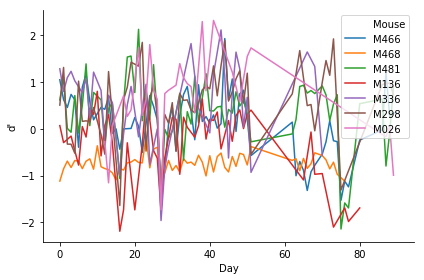

       count      mean       std       min       25%       50%       75%  \
Mouse                                                                      
M026    34.0  0.672060  0.897313 -1.729756  0.272814  0.785275  1.088341   
M136    52.0 -0.344956  0.782379 -2.189350 -0.663327 -0.164153  0.215801   
M298    62.0  0.577563  0.760540 -1.638068  0.201284  0.646884  1.059353   
M336    41.0  0.487965  0.891259 -1.959964 -0.108541  0.719622  1.128253   
M466    70.0  0.088228  0.687010 -1.525821 -0.276389  0.166881  0.561922   
M468    65.0 -0.742213  0.192200 -1.213459 -0.855039 -0.727617 -0.638235   
M481    70.0  0.344021  0.745022 -2.141198  0.017253  0.475595  0.765108   

            max  
Mouse            
M026   2.319343  
M136   0.803211  
M298   1.924490  
M336   2.116079  
M466   1.931813  
M468  -0.158202  
M481   2.129098  
count    111.000000
mean       1.330505
std        0.883885
min       -1.016612
25%        0.731693
50%        1.306983
75%        1.925254
max        3.

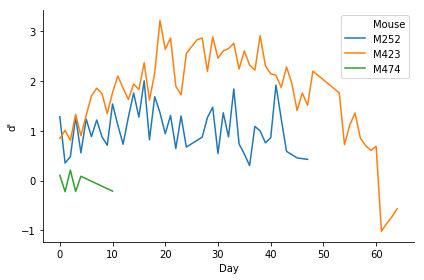

       count      mean       std       min       25%       50%       75%  \
Mouse                                                                      
M252    44.0  1.030714  0.438687  0.300945  0.699384  0.967237  1.284441   
M423    60.0  1.709187  0.938168 -1.016612  1.323308  1.853100  2.302865   
M474     7.0 -0.030945  0.182541 -0.223533 -0.215448  0.036504  0.095926   

            max  
Mouse            
M252   2.000424  
M423   3.211193  
M474   0.209460  


In [863]:
#list_daily_perfromances()
#TWOway_anovaRM()
dPrime_dataframe()
#delay_time_bin_ratios()
#t_test_day_night_performance()
#draw_doubleplot()
#rolling_mean()
#make_augmented_dickey_fuller_test()
#draw_histogram()
#draw_jointplot()
#violinplots("sessiontrials")
#violinplots("sessiontime")